# Adaptive hyperparameter optimization
This notebook shows off a model selection algorithm that is now a part of Dask-ML, Hyperband.

## Problem
Any machine learning model requires tuning many "hyper-parameters" for good performance, and is mentioned in the Scikit-Learn docs under "[Tuning the hyper-parameters of an estimator]".

This notebook will walk through a case of "image denoising". Getting good performance out of this model requires tuning these parameters:

``` python
params = {
    'module__init',
    'module__activation',
    'optimizer',
    'batch_size',
    'optimizer__lr',
    'optimizer__weight_decay',
}
```

These are incredibly important, and fairly basic. They answer the questions of

* How is the network initialization?
* How is the model optimized? What are some of the hyper-parameters for `optimizer`?

[Tuning the hyper-parameters of an estimator]:http://scikit-learn.org/stable/modules/grid_search.html


This notebook looks at a realistic use case of hyperparameter optimization. To do this, this notebook uses

* a realistic deep learning model
* a realistic set of hyperparameters

There are many hyperparameter for any model or framework. These can be specific to the model, or be related to the optimization framework used to minimize the model.

This notebook will show

* the model input and output (noisy and clean images respectively)
* the parameter space we are searching over
* a newly developed hyperparameter optimization algorithm and it's integration
* a comparison with 3 hyperparameter selection algorithms

## Setup

In [1]:
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

In [2]:
import distributed
from distributed import Client, LocalCluster

In [3]:
import socket
s=socket.socket()
s.bind(("", 0))
port = s.getsockname()[1]
s.close()

In [4]:
# cluster = LocalCluster(n_workers=-1)
# client = Client(cluster)

# client = Client(f"localhost:{port}")
# client


In [5]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

In [6]:
cluster = LocalCUDACluster(dashboard_address=f"127.0.0.1:{port}")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:57411/status,
Dashboard: http://127.0.0.1:57411/status,Workers: 2
Total threads: 2,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38673,Workers: 2
Dashboard: http://127.0.0.1:57411/status,Total threads: 2
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:39053,Total threads: 1
Dashboard: http://127.0.0.1:38193/status,Memory: 93.78 GiB
Nanny: tcp://127.0.0.1:46237,


In [7]:
import subprocess
def debug_loop():
    # subprocess.call("pip install git+https://github.com/stsievert/dask-ml@hyperband-scale".split(" "))
    import dask_ml
    return dask_ml.__version__

In [8]:
%time debug_loop()

CPU times: user 349 ms, sys: 61.9 ms, total: 411 ms
Wall time: 398 ms


'2023.3.24'

In [9]:
client.run(debug_loop)

{'tcp://127.0.0.1:35777': '2023.3.24', 'tcp://127.0.0.1:39053': '2023.3.24'}

In [10]:
%time client.restart()

2023-11-12 11:10:30,064 - distributed.nanny - WARNING - Restarting worker
2023-11-12 11:10:30,091 - distributed.nanny - WARNING - Restarting worker


CPU times: user 135 ms, sys: 62.1 ms, total: 197 ms
Wall time: 2.22 s


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:57411/status,
Dashboard: http://127.0.0.1:57411/status,Workers: 2
Total threads: 2,Total memory: 187.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38673,Workers: 2
Dashboard: http://127.0.0.1:57411/status,Total threads: 2
Started: Just now,Total memory: 187.57 GiB
Comm: tcp://127.0.0.1:43801,Total threads: 1
Dashboard: http://127.0.0.1:45969/status,Memory: 93.78 GiB
Nanny: tcp://127.0.0.1:46237,


In [11]:
%time client.upload_file('autoencoder.py')

CPU times: user 1.39 s, sys: 223 ms, total: 1.61 s
Wall time: 3.41 s


{'tcp://127.0.0.1:33591': {'status': 'OK'},
 'tcp://127.0.0.1:43801': {'status': 'OK'}}

In [12]:
import dask_ml
from dask_ml.model_selection import HyperbandSearchCV
import dask_ml
dask_ml.__version__

'2023.3.24'

## Data
See below for an image.

In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import noisy_mnist
chunk_size = 70_000 // 3
_X, _y = noisy_mnist.dataset()
_X = _X[:chunk_size * 3]
_y = _y[:chunk_size * 3]

/home/barradd/Documents/GitHub/cloud-ml-examples/dask/notebooks/noisy_mnist.py:31: FutureWarning: `seed` is a deprecated argument name for `random_noise`. It will be removed in version 0.23. Please use `rng` instead.
  img = random_noise(x, seed=seed, **noise)


In [15]:
_X.shape, _X.dtype, _X.min(), _X.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [16]:
_y.shape, _y.dtype, _y.min(), _y.max()

((69999, 784), dtype('float32'), 0.0, 1.0)

In [17]:
import dask.array as da
n, d = _X.shape
X = da.from_array(_X, chunks=(n // 3, d))
y = da.from_array(_y, chunks=n // 3)
X, y

(dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>,
 dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>)

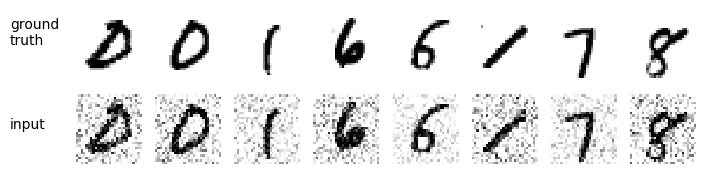

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state

rng = check_random_state(42)
cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 2*w), ncols=cols, nrows=2)
for col, (upper, lower) in enumerate(zip(axs[0], axs[1])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        lower.text(-28, 14, 'input')
    i = rng.choice(len(X))
    noisy = X[i].reshape(28, 28)
    clean = y[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=lower, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
plt.savefig("results/input-output.svg", bbox_inches="tight")
plt.show()

## Model

I use a deep learning library (PyTorch) for this model, at least through the scikit-learn interface for PyTorch, [skorch].

[skorch]:https://github.com/dnouri/skorch

In [19]:
from autoencoder import Autoencoder, NegLossScore
import torch
# from sklearn.model_selection import ParameterSampler
# import torch

def trim_params(**kwargs):
    if kwargs['optimizer'] != 'Adam':
        kwargs.pop('optimizer__amsgrad', None)
    if kwargs['optimizer'] == 'Adam':
        kwargs.pop('optimizer__lr', None)
    if kwargs['optimizer'] != 'SGD':
        kwargs.pop('optimizer__nesterov', None)
        kwargs.pop('optimizer__momentum', None)
    kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
    return kwargs

class TrimParams(NegLossScore):
    def set_params(self, **kwargs):
        kwargs = trim_params(**kwargs)
        return super().set_params(**kwargs)

model = TrimParams(
    module=Autoencoder,
    criterion=torch.nn.BCELoss,
    warm_start=True,
    train_split=None,
    max_epochs=1,
    callbacks=[]
)

I don't show it here; I'd rather concentrate on tuning hyperparameters. But briefly, it's a simple fully connected 3 hidden layer autoencoder with a latent dimension of 49.

## Parameters

The parameters I am interested in tuning are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD
    
After looking at the results, I think I was too exploratory in my tuning of step size. I should have experimented with it more to determine a reasonable range.

In [20]:
import numpy as np

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ["SGD"] * 5 + ["Adam"] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}

I am testing `optimizer` to be `SGD` or `Adam` to test "[The Marginal Value of Adaptive Gradient Methods in Machine Learning][marginal]". From their abstract,

> We observe that the solutions found by adaptive methods generalize worse (often sig- nificantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.

Their experiments in Figure 1b show that non-adaptive methods (SGD and heavy ball) perform much better than adaptive methods.

They have to do some tuning for this. **Can we replicate their result?**

[marginal]:https://arxiv.org/pdf/1705.08292.pdf

In [21]:
# # for debugging; ignore this cell
# from sklearn.linear_model import SGDClassifier
# from sklearn.datasets import make_classification
# from sklearn.model_selection import ParameterSampler
# import dask.array as da
# import numpy as np
# model = SGDClassifier()
# params = {'alpha': np.logspace(-7, 0, num=int(1e6))}

# n, d = int(10e3), 700
# _X, _y = make_classification(n_samples=n, n_features=d,
#                              random_state=1)
# X = da.from_array(_X, chunks=(n // 10, d))
# y = da.from_array(_y, chunks=n // 10)
# X, y

In [22]:
import json
# import msgpack

def fmt(obj):
    if isinstance(obj, list):
        return [fmt(v) for v in obj]
    if isinstance(obj, dict):
        return {k: fmt(v) for k, v in obj.items()}
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj


In [42]:

import msgpack
# from sklearn.externals import joblib
import dask.array as da

def save_search(search, today, prefix, X, y):
    pre = f"{today}-{prefix}-"

    with open(pre + "test.npz", "wb") as f:
        y_hat = search.predict(X)
        y_hat = y_hat.compute()
        np.savez(f, X=X, y=y, y_hat=y_hat)
    # skorch models aren't pickable
    with open(pre + "params.json", "w") as f:
        params = {k: fmt(v) for k, v in search.get_params().items() if "estimator" not in k and "param_distribution" not in k}
        json.dump(params, f)
    # with open(pre + "best-model.joblib", "wb") as f:
    #     joblib.dump(search.best_estimator_, f)
    with open(pre + "best-params-and-score.json", "w") as f:
        json.dump({"params": search.best_params_, "score": search.best_score_}, f)

    with open(pre + "history.json", 'w') as f:
        json.dump(search.history_, f)

    with open(pre + "cv_results.json", 'w') as f:
        json.dump(fmt(search.cv_results_), f)

In [24]:
# today = "2019-03-24"
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2023-11-12


## Hyperparameter optimization

In [25]:
X

dask.array<array, shape=(69999, 784), dtype=float32, chunksize=(23333, 784), chunktype=numpy.ndarray>

In [26]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_test

(dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>,
 dask.array<concatenate, shape=(7002, 784), dtype=float32, chunksize=(2334, 784), chunktype=numpy.ndarray>)

In [27]:
y_train

dask.array<concatenate, shape=(62997, 784), dtype=float32, chunksize=(20999, 784), chunktype=numpy.ndarray>

In [28]:
from sklearn.linear_model import SGDClassifier

max_iter = 243
history = {}
cv_results = {}
searches = {}

In [29]:
from dask_ml.model_selection import HyperbandSearchCV

fit_params = {}
if isinstance(model, SGDClassifier):
    fit_params = {'classes': da.unique(y).compute()}
   

### Hyperband

In [30]:
search = HyperbandSearchCV(model, params, max_iter, random_state=42)

In [31]:
# model

In [32]:
y_train.shape

(62997, 784)

In [33]:
search.fit(X_train, y_train, **fit_params)

This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.16605806350708
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.0006415843963623
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.0111913681030273
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.2688851356506348
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.0398223400115967
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type o

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=243,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'S...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  random_state=42)

In [34]:
timing_stats = timing_stats = client.profile(filename="hyperband.html")
with open("hyperband-timing.json", "w") as f:
    json.dump(timing_stats[0], f)

In [35]:
search.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [36]:
search.best_score_

-1.9904462099075317

In [37]:
search.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0.000776050333513357,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.7387387387387387,
 'optimizer__lr': 2.209756114795902,
 'optimizer': 'SGD',
 'module__init': 'kaiming_uniform_',
 'module__activation': 'LeakyReLU',
 'batch_size': 32}

In [43]:
save_search(search, today, "hyperband", X_test.compute(), y_test.compute())

/home/barradd/miniconda3/envs/rapids-23.10c/lib/python3.10/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 17.49 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### Hyperband + SOP

In [44]:
search_patience = HyperbandSearchCV(model, params, max_iter, random_state=42, patience=True)

In [45]:
search_patience.fit(X_train, y_train, **fit_params)

This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 1.0502396821975708
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.046126127243042
steps = 1, loss = 2.2760252952575684
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.0375852584838867
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 1.359345555305481
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type o

HyperbandSearchCV(estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                  max_iter=243,
                  parameters={'batch_size': [32, 64, 128, 256, 512],
                              'module__activation': ['ReLU', 'LeakyReLU', 'ELU',
                                                     'PReLU'],
                              'module__init': ['xavier_uniform_',
                                               'xavier_normal_',
                                               'kaiming_uniform_',
                                               'kaiming_normal_'],
                              'optimizer': ['SGD', 'SGD', 'SGD', 'S...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                              'optimizer__nesterov': [True],
                              'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, 0, 0, 0, 0, 0,
                                                          0, 0, ...],
                              'train_split': [None]},
                  patience=True, random_state=42)

In [46]:
save_search(search_patience, today, "hyperband-w-patience", X_test.compute(), y_test.compute())

/home/barradd/miniconda3/envs/rapids-23.10c/lib/python3.10/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.14 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [47]:
timing_stats = timing_stats = client.profile(filename="hyperband.html")
with open("hyperband+sop-timing.json", "w") as f:
    json.dump(timing_stats[0], f)

In [48]:
search_patience.best_estimator_

<class '__main__.TrimParams'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=196, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=196, out_features=784, bias=True)
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Linear(in_features=784, out_features=784, bias=True)
      (3): Sigmoid()
    )
  ),
)

In [49]:
search_patience.best_score_

-2.1147964000701904

In [50]:
search_patience.best_params_

{'train_split': None,
 'optimizer__weight_decay': 0.0005912508413831881,
 'optimizer__nesterov': True,
 'optimizer__momentum': 0.006006006006006006,
 'optimizer__lr': 6.057344614930285,
 'optimizer': 'SGD',
 'module__init': 'kaiming_normal_',
 'module__activation': 'LeakyReLU',
 'batch_size': 512}

### Visualizing output of best estimator

In [51]:
noisy_test = X_test.compute()

In [52]:
clean_hat = search.best_estimator_.predict(noisy_test)
clean_hat.shape

(7002, 2, 784)

In [70]:
i = rng.choice(len(X_test))
print (i , type (clean_hat[i]) )
clean_hat[i].size
clean_hat[i].shape

5578 <class 'numpy.ndarray'>


(2, 784)

In [73]:
last_dimension = clean_hat[i][1]
print (last_dimension.shape)
last_dimension.reshape(28,28)

(784,)


array([[0.00473381, 0.00473381, 0.00473381, 0.00473381, 0.00473381,
        0.00473381, 0.00473381, 0.00473381, 0.00473381, 0.00473381,
        0.00473381, 0.00473381, 0.00473377, 0.00473381, 0.00473391,
        0.00473381, 0.00473381, 0.00473381, 0.00473381, 0.00473381,
        0.00473381, 0.00473381, 0.00473381, 0.00473381, 0.00473381,
        0.00473381, 0.00473381, 0.00473381],
       [0.00473381, 0.00473381, 0.00473381, 0.00473381, 0.00473381,
        0.00473401, 0.00473513, 0.00473244, 0.00472196, 0.00497092,
        0.00507018, 0.0048708 , 0.00544278, 0.00540282, 0.00525905,
        0.00485883, 0.00484402, 0.00538665, 0.00575181, 0.00483513,
        0.00484688, 0.00476879, 0.00474633, 0.00473381, 0.00473381,
        0.00473381, 0.00473381, 0.00473381],
       [0.00473381, 0.00473381, 0.00473381, 0.00473381, 0.00473493,
        0.00566162, 0.00602695, 0.0059309 , 0.00538978, 0.00569121,
        0.00655963, 0.00839526, 0.01026299, 0.01052164, 0.01428741,
        0.01791159, 0.0203

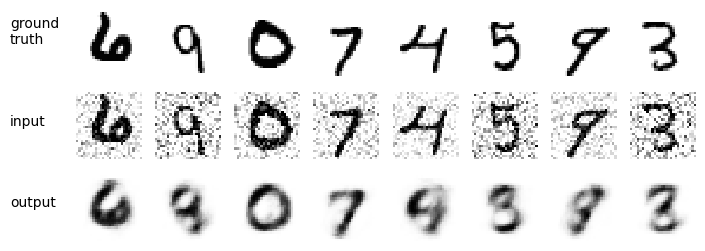

In [74]:
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns

cols = 8
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)

rng = check_random_state(42)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = rng.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i][1].reshape(28,28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray_r'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
# plt.savefig("imgs/best-out.svg", bbox_inches="tight")
plt.show()

### Setting parameters for Hyperband
Need to know two things:

1. how many "epochs" or "passes through data" to train model
2. how many configs to evaluate
    * this is some measure of how complex the search space is
    
This determines

* The `max_iter` argument for `HyperbandCV`
* the chunks size for the array to pass in


## Comparison with early stopping

In [75]:
total_calls = search.metadata_['partial_fit_calls']
num_calls = max_iter

n_workers = 32 or len(client.cluster.workers)
num_models = max(n_workers, total_calls // num_calls)
num_calls, num_models, search.metadata_['partial_fit_calls']

(243, 32, 4743)

In [76]:
from dask_ml.model_selection import IncrementalSearchCV

passive_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=False,
    n_initial_parameters=num_models,
    max_iter=num_calls,
    random_state=42
)

In [77]:
passive_search.fit(X_train, y_train, **fit_params)

/home/barradd/miniconda3/envs/rapids-23.10c/lib/python3.10/site-packages/dask_ml/model_selection/_incremental.py:1047: FutureWarning: decay_rate is deprecated in InverseDecaySearchCV. Use InverseDecaySearchCV to use decay_rate=0
  warn(


This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 1.3877140283584595
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.112208366394043
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.5741069316864014
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.0165882110595703
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 1.1014668941497803
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type 

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=243, n_initial_parameters=32,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_norm...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    random_state=42)

In [78]:
save_search(passive_search, today, "passive", X_test.compute(), y_test.compute())

/home/barradd/miniconda3/envs/rapids-23.10c/lib/python3.10/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 12.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [79]:
timing_stats = client.profile()

with open("final-final-timings.json", "w") as f:
    json.dump(timing_stats, f)

* patience: `max_iter // 8` (10 epochs)
* n_initial: `2 * num_models`

This requires choosing

* the explore/exploit tradeoff (`patience` vs `n_initial`)
* some estimate on many models will take advantage of `patience` to get total number of partial fit calls

In [80]:
from dask_ml.model_selection import IncrementalSearchCV

patience_search = IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=max_iter // 10,
    n_initial_parameters=2 * num_models,
    max_iter=num_calls,
    random_state=42,
)

In [81]:
patience_search.fit(X_train, y_train, **fit_params)

/home/barradd/miniconda3/envs/rapids-23.10c/lib/python3.10/site-packages/dask_ml/model_selection/_incremental.py:1047: FutureWarning: decay_rate is deprecated in InverseDecaySearchCV. Use InverseDecaySearchCV to use decay_rate=0
  warn(


This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 1.8846770524978638
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 0.7321285009384155
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.0346126556396484
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 2.3841097354888916
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type of y_hat tensor after skorch : <class 'torch.Tensor'>
steps = 1, loss = 0.700863778591156
This is the shape of y_hat tensor after skorch : torch.Size([12600, 784])
This is the type 

IncrementalSearchCV(decay_rate=0,
                    estimator=<class '__main__.TrimParams'>[uninitialized](
  module=<class 'autoencoder.Autoencoder'>,
),
                    max_iter=243, n_initial_parameters=64,
                    parameters={'batch_size': [32, 64, 128, 256, 512],
                                'module__activation': ['ReLU', 'LeakyReLU',
                                                       'ELU', 'PReLU'],
                                'module__init': ['xavier_uniform_',
                                                 'xavier_normal_',
                                                 'kaiming_uniform_',
                                                 'kaiming_norm...
       0.98098098, 0.98198198, 0.98298298, 0.98398398, 0.98498498,
       0.98598599, 0.98698699, 0.98798799, 0.98898899, 0.98998999,
       0.99099099, 0.99199199, 0.99299299, 0.99399399, 0.99499499,
       0.995996  , 0.996997  , 0.997998  , 0.998999  , 1.        ]),
                                'optimizer__nesterov': [True],
                                'optimizer__weight_decay': [0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, 0, 0, 0, 0, 0,
                                                            0, 0, ...],
                                'train_split': [None]},
                    patience=24, random_state=42)

In [82]:
patience_search.best_score_

-2.0357985496520996

In [83]:
save_search(patience_search, today, "patience", X_test.compute(), y_test.compute())

/home/barradd/miniconda3/envs/rapids-23.10c/lib/python3.10/site-packages/distributed/client.py:3149: UserWarning: Sending large graph of size 11.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [84]:
timing_stats = client.profile()

In [85]:
with open("final-timings.json", "w") as f:
    json.dump(timing_stats, f)

In [86]:
data, fig = client.get_task_stream(plot=True)

In [87]:
len(data)

28442

In [88]:
fig

figure(id='p17873972', ...)

In [ ]:
saved_ = Out[46]

In [89]:
import pandas as pd
df = pd.DataFrame(list(data))

In [90]:
df.head()

,stimulus_id,worker,nbytes,type,typename,metadata,thread,startstops,status,key
0,task-finished-1699777264.968672,tcp://127.0.0.1:43801,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140324047210240,"({'action': 'compute', 'start': 1699777262.616...",OK,_partial_fit-6ddf940c-193a-46b1-9303-1911542d89a9
1,task-finished-1699777266.6243997,tcp://127.0.0.1:33591,2146,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140685143439104,"({'action': 'compute', 'start': 1699777262.579...",OK,_partial_fit-d9ee6456-959d-41fa-8972-125a44bbddf8
2,task-finished-1699777269.060649,tcp://127.0.0.1:43801,2148,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140324047210240,"({'action': 'compute', 'start': 1699777264.973...",OK,_partial_fit-e18d49b4-f2db-4ea7-ac62-2c95b8242543
3,task-finished-1699777269.514842,tcp://127.0.0.1:33591,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140685143439104,"({'action': 'compute', 'start': 1699777266.628...",OK,_partial_fit-17b03476-731e-405b-8ccd-89f01bbd1db8
4,task-finished-1699777271.3140385,tcp://127.0.0.1:43801,2153,b'\x80\x05\x95\x16\x00\x00\x00\x00\x00\x00\x00...,tuple,{},140324047210240,"({'action': 'compute', 'start': 1699777269.065...",OK,_partial_fit-5b2e7fd1-c6e4-4166-9767-6c1a67a4570c


In [91]:
df.to_msgpack("times.msgpack")

AttributeError: 'DataFrame' object has no attribute 'to_msgpack'

In [92]:
type(data)

tuple

In [93]:
len(data)

28442